In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeSherbrooke # For simulation with realistic noise


In [2]:
def load_qubo_and_build_hamiltonian(file_path="qubo_data.json"):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        qubo_data = json.load(f)

    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset, backend_total_qubits=127): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    objective_func_vals.append(cost_float)
    
    numOptimisations = numOptimisations + 1
    # Your desired print format:
    print(f"Params: {params}, Cost: {cost_float}, Optimisation Round: {numOptimisations}") 
    
    return cost_float

In [3]:
cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian("qubo_data.json")
print("Cost Function Hamiltonian (from QUBO):", cost_hamiltonian)
print("Constant offset:", constant_offset)
print(f"Number of qubits (inferred from terms): {num_qubits}")
print("Problem type:", problem_type)

Cost Function Hamiltonian (from QUBO): SparsePauliOp(['IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIZIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IZIIZIIII', 'IIZZIIIII', 'ZIIZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Constant offset: 0
Number of qubits (inferred from terms): 9
Problem type: maximum_cut


In [4]:
# 2. Define QAOA Ansatz
#    **************** QAOA Customization Options ****************
#    a. `cost_operator`: The problem Hamiltonian (loaded from QUBO).
#    b. `reps` (p): Number of QAOA layers. Higher 'reps' can improve solution quality
#                   but increases circuit depth and parameters. Start small (e.g., 1-3).
#    c. `initial_state`: QuantumCircuit for the initial state. Default is Hadamard transform.
#    d. `mixer_operator`: Mixer Hamiltonian. Default is sum_i X_i. Custom mixers can be used.
#    e. `upto_diag`: If True, cost operator assumed diagonal in Z basis (typical for QUBOs).
#    ************************************************************
reps_p = 2 # Example: QAOA depth (number of layers) 2 found to be optimal for sherbrookenoise model for 6 qubit problem

if num_qubits == 0:
    print("Error: Number of qubits is 0. Cannot create QAOAAnsatz. Check your qubo_data.json")
    exit()

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps_p)
circuit.measure_all() 

print("Ansatz Parameters:", circuit.parameters)
#circuit.draw()

Ansatz Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


In [5]:
# 3. Choose Backend and Transpile
#    **************** QAOA Customization Options ****************
#    a. `backend`: Simulator (AerSimulator, FakeBackend) or real quantum device.
#    b. `optimization_level` (transpiler): 0 (no opt) to 3 (heavy opt).
#    ************************************************************
backend_simulator = AerSimulator() # Ideal simulator
#backend_simulator = AerSimulator.from_backend(FakeBrisbane()) # Simulator with IBM_Brisbane specific noise model
#backend_simulator = AerSimulator.from_backend(FakeSherbrooke()) # Simulator with IBM_Sherbroke specific noise model

pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)
candidate_circuit = pm.run(circuit)
candidate_circuit.depth()
#candidate_circuit.draw()

20

In [6]:
# 4. Set Initial Parameters for QAOA
#    **************** QAOA Customization Options ****************
#    - Number of parameters = 2 * reps_p (gammas for cost, betas for mixer).
#    - Good initial points can help optimization.
#      Examples: random values, fixed guesses (e.g., gammas in [0, 2*pi], betas in [0, pi]).
#    ************************************************************
num_params = 2 * reps_p
initial_betas = (np.random.rand(reps_p) * np.pi).tolist()
#initial_gammas = (np.random.rand(p_depth) * (np.pi / 2)).tolist() #the /2 is a relic from the utility scale example that doesnt seem needed
initial_gammas = (np.random.rand(reps_p) * (np.pi)).tolist()
initial_params = initial_betas + initial_gammas
    
# 5. Optimization using Estimator
#    **************** QAOA Customization Options ****************
#    a. `Estimator options`: `default_shots` (more shots -> less statistical noise).
#    b. `minimize` function (scipy.optimize):
#        - `method`: e.g., "COBYLA", "NELDER-MEAD", "SPSA", "L-BFGS-B".
#                    COBYLA and SPSA are often good for noisy quantum optimizations.
#        - `tol`: Tolerance for termination.
#        - `options={'maxiter': ...}`: Max optimizer iterations.
#    ************************************************************

# Global variables
objective_func_vals = []  
numOptimisations = 0

estimator = Estimator(mode=backend_simulator)
# estimator.options.default_shots = 1024 # Default is 4000 for EstimatorV2 if not using shots option in run.

print("Starting optimization...")
result = minimize(
    cost_func_estimator,
    initial_params,
    args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
    method="COBYLA",
    tol=1e-3,
    options={"maxiter": 1000}, # Adjust as needed
)
print("Optimization Result:")
print(result)

Starting optimization...
Params: [2.39980499 2.75497225 0.4672335  2.62484718], Cost: -0.91796875, Optimisation Round: 1
Params: [3.39980499 2.75497225 0.4672335  2.62484718], Cost: 5.5693359375, Optimisation Round: 2
Params: [2.39980499 3.75497225 0.4672335  2.62484718], Cost: 1.015625, Optimisation Round: 3
Params: [2.39980499 2.75497225 1.4672335  2.62484718], Cost: -1.67041015625, Optimisation Round: 4
Params: [2.39980499 2.75497225 1.4672335  3.62484718], Cost: 0.18212890625, Optimisation Round: 5
Params: [1.48072392 2.48103268 1.57383473 2.36239094], Cost: -0.013671875, Optimisation Round: 6
Params: [2.76618669 2.51845074 1.55927382 2.39824046], Cost: -0.0615234375, Optimisation Round: 7
Params: [2.39112463 3.24200036 1.50968883 2.52032057], Cost: 0.216796875, Optimisation Round: 8
Params: [2.39836022 2.73650251 1.21852864 2.60744967], Cost: -1.23779296875, Optimisation Round: 9
Params: [2.47607008 2.77770367 1.45838776 2.72083505], Cost: -2.03369140625, Optimisation Round: 10
Pa

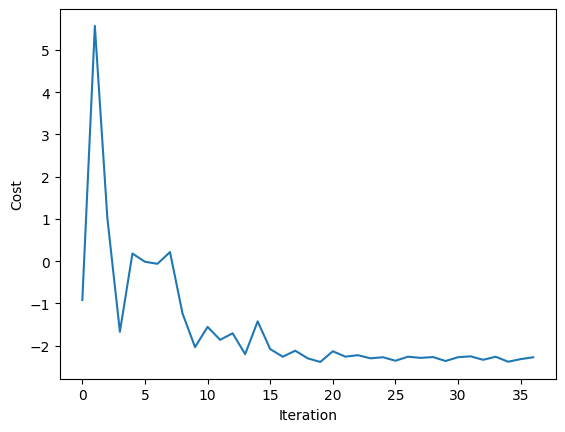

In [7]:
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [8]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
#optimized_circuit.draw() #commented out bc long output

In [9]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="e3d76332de187f9b82dbd1904444ae8aaca1b80ed6fa6b8ae43d3b8f2641c0eea75884a158e0208d8d46c6d03551260f840427bfee34f4e323e13454fbf86fdf",
    overwrite=True,
    set_as_default=True,
)


service = QiskitRuntimeService(channel="ibm_quantum")
#backend_name = "ibm_brisbane"
backend_name = "ibm_sherbrooke"
backend = service.backend(backend_name)

/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_32533/1732015256.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


In [ ]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )

tag1 = str(problem_type).replace(" ", "_") # e.g., 'bin_packing' or 'maximum_cut'
tag2 = f"nq={num_qubits}" # e.g., 'nq=6'
tag3 = f"p={reps_p}" # e.g., 'p=2'
job_tags_list = [tag1, tag2, tag3]
print(f"Submitting job with tags: {job_tags_list}")

job = sampler.run([pub], shots=int(1e4))
jobID = job.job_id()


job.update_tags(new_tags=job_tags_list)
print(f"Successfully updated tags for job {jobID}.")


print(f"You can monitor the job status at: https://quantum.ibm.com/jobs/{jobID}")
print('This job\'s job ID is:', jobID)
print(f"      Associated Tags: {job_tags_list}")
print("Submission script finished.")

Submitting job with tags: ['maximum_cut', 'nq=9', 'p=2']


IBMInputValueError: 'The instruction rzz is supported only for angles in the range [0, pi/2], but an angle of 2.669466722168208 has been provided.'